In [22]:
import sys;

import torch;
import torch.nn as nn;
import torch.optim as optim

import numpy as np;
import pickle;

import matplotlib.pyplot as plt;

import pdb
import time

import math

import os

print("Packages:");
print("torch.__version__ = " + str(torch.__version__));
print("numpy.__version__ = " + str(np.__version__));

Packages:
torch.__version__ = 1.5.0
numpy.__version__ = 1.18.1


In [23]:
# Define heat map so we may plot our results

def heatmap2d(arr: np.ndarray):
    plt.imshow(arr, cmap='winter')
    plt.savefig('heatmap_3.png', dpi=500)
    plt.colorbar()
    plt.show()

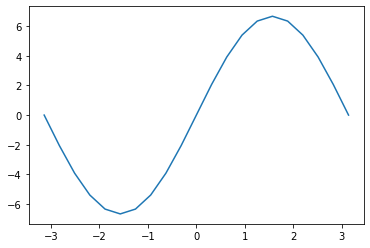

In [24]:
# Discretize a domain
C = math.pi
h = 2*C/(20)
x = np.arange(-C, C+h, h)
N = len(x)

# Number of functions for our data
M = 50

z_tensor = torch.zeros(M,1,1,N)
discretization = torch.zeros(M,1,1,N)
z_deriv_tensor = torch.zeros(M,1,1,N)

# Generate data
for i in range(0,M):
    a = np.random.uniform(0,10,1)
    b = np.random.uniform(0.3,0.5,1)
    z = a*np.sin(x)
#    z = a*np.exp(-b*(x**2))
    
    z_tensor[i,:,:] = torch.tensor(z)
    z_tensor = z_tensor.float()
    discretization[i,0,0,:] = torch.tensor(x)
    
    for j in range(1,len(z)-1):
        z_deriv_tensor[i,0,0,j] = (z[j+1] - 2*z[j] + z[j-1])/(h**2)
    
    
# Reshape tensor
discretization_reshape = torch.reshape(discretization, (-1,))

# Initialize tensors for input data

z_NN_input_branch_0 = z_tensor.repeat(1,N,1,1)
z_NN_input_branch_np = z_NN_input_branch_0.detach().numpy().squeeze()
z_NN_input_branch_np = np.reshape(z_NN_input_branch_np, (N*M,N))


z_NN_input_branch = torch.tensor(z_NN_input_branch_np)
z_NN_input_trunk = discretization_reshape.repeat(1,1,1,1)
z_NN_input_trunk = torch.reshape(z_NN_input_trunk, (N*M,1))
z_NN_target = torch.reshape(z_deriv_tensor, (N*M,1))

#print(z_NN_target)
#print(z_NN_input_trunk)
#print(z_NN_target)

    

plt.plot(x,z)

In [25]:
# Create neural networks for Unstacked DeepONet

class Unstacked_Branch(nn.Module):
    def __init__(self):
        super(Unstacked_Branch, self).__init__()
        self.layer1 = nn.Linear(N, 200, bias=True)
        self.layer2 = nn.Linear(200,1)
        self.activation = nn.ReLU()
    def forward(self, x):
        out = self.layer1(x)
        out = self.activation(out)
        out = self.layer2(out)
        return out
    
    
class Trunk(nn.Module):
    def __init__(self):
        super(Trunk, self).__init__()
        self.layer1 = nn.Linear(1, 200, bias=True)
        self.layer2 = nn.Linear(200,1)
        self.activation = nn.ReLU()
    def forward(self, x):
        out = self.layer1(x)
        out = self.activation(out)
        out = self.layer2(out)
        return out


Unstacked_Branch = Unstacked_Branch()
Trunk = Trunk()
print(Unstacked_Branch)
print(Trunk)

Unstacked_Branch(
  (layer1): Linear(in_features=21, out_features=200, bias=True)
  (layer2): Linear(in_features=200, out_features=1, bias=True)
  (activation): ReLU()
)
Trunk(
  (layer1): Linear(in_features=1, out_features=200, bias=True)
  (layer2): Linear(in_features=200, out_features=1, bias=True)
  (activation): ReLU()
)


In [26]:
# Define PINN loss
def MSE_loss(u, f):
    loss = torch.sum( (u-f)**2)
    return loss;

loss_func = MSE_loss
#loss_func = torch.nn.MSELoss()

In [37]:
###### Iteratively run this code to train the network

I = 1000

loss_vector = np.zeros(shape=(I,1))
index_vector = np.zeros(shape=(I,1))
num_epochs = I
target = z_NN_target
for i in np.arange(0,num_epochs):
    index_vector[i-1] = i
    
    optimizer_1 = optim.Adam(Unstacked_Branch.parameters(), lr=0.00001); optimizer_1.zero_grad()  
    optimizer_2 = optim.Adam(Trunk.parameters(), lr=0.00001); optimizer_2.zero_grad() 
    output_1 = Unstacked_Branch(z_NN_input_branch); output_2 = Trunk(z_NN_input_trunk)
        
    loss = loss_func(target, torch.mul(output_1, output_2))
    loss.backward()
    loss_vector[i-1] = loss.detach()
    optimizer_1.step(); optimizer_2.step()

    
print("DNN training finished.")
print(loss_vector[I-1])


DNN training finished.
[5.05764103]


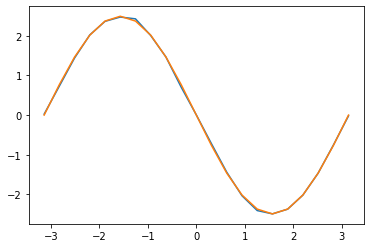

In [38]:
plt.plot(x,torch.mul(output_1, output_2).detach().numpy()[0:21])
plt.plot(x, target.detach().numpy()[0:21])

In [39]:
# Create neural networks for Stacked DeepONet

class Stacked_Branch(nn.Module):
    def __init__(self):
        super(Stacked_Branch, self).__init__()
        self.layer1 = nn.Linear(N, 200, bias=True)
        self.layer2 = nn.Linear(200,1)
        self.activation = nn.ReLU()
    def forward(self, x):
        out = self.layer1(x)
        out = self.activation(out)
        out = self.layer2(out)
        return out
    
    
class Trunk(nn.Module):
    def __init__(self):
        super(Trunk, self).__init__()
        self.layer1 = nn.Linear(1, 200, bias=True)
        self.layer2 = nn.Linear(200,2)
        self.activation = nn.ReLU()
    def forward(self, x):
        out = self.layer1(x)
        out = self.activation(out)
        out = self.layer2(out)
        return out


Stacked_Branch_1 = Stacked_Branch()
Stacked_Branch_2 = Stacked_Branch()
Trunk = Trunk()
print(Unstacked_Branch)
print(Trunk)

Unstacked_Branch(
  (layer1): Linear(in_features=21, out_features=200, bias=True)
  (layer2): Linear(in_features=200, out_features=1, bias=True)
  (activation): ReLU()
)
Trunk(
  (layer1): Linear(in_features=1, out_features=200, bias=True)
  (layer2): Linear(in_features=200, out_features=2, bias=True)
  (activation): ReLU()
)


In [48]:
I = 1000

loss_vector = np.zeros(shape=(I,1))
index_vector = np.zeros(shape=(I,1))
num_epochs = I
target = z_NN_target
for i in np.arange(0,num_epochs):
    index_vector[i-1] = i
    
    optimizer_1 = optim.Adam(Stacked_Branch_1.parameters(), lr=0.00001); optimizer_1.zero_grad() 
    optimizer_2 = optim.Adam(Stacked_Branch_1.parameters(), lr=0.00001); optimizer_2.zero_grad()
    optimizer_3 = optim.Adam(Trunk.parameters(), lr=0.00001); optimizer_3.zero_grad() 
    output_1 = Stacked_Branch_1(z_NN_input_branch); 
    output_2 = Stacked_Branch_2(z_NN_input_branch)
    output_3 = Trunk(z_NN_input_trunk)
        
    loss = loss_func(target, torch.mul(output_1, output_3[:,0:1]) + torch.mul(output_2, output_3[:,1:2]))
    loss.backward()
    loss_vector[i-1] = loss.detach()
    optimizer_1.step(); optimizer_2.step();
    optimizer_3.step();

    
print("DNN training finished.")
print(loss_vector[I-1])


DNN training finished.
[7.88078785]


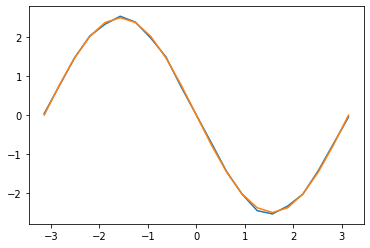

In [49]:
y = torch.mul(output_1, output_3[:,0:1]) + torch.mul(output_2, output_3[:,1:2])
plt.plot(x, y.detach().numpy()[0:21])
plt.plot(x, target.detach().numpy()[0:21])